In [74]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
from collections import namedtuple, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
from final_algo import attr_threshold
from paper_sims_util import confusion
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [488]:
from final_algo import GET_ALGOS_ROC

In [489]:
algos = GET_ALGOS_ROC()
sh_alg = algos['SH']

In [494]:
from paper_sims_util import random_graph
X = np.random.multivariate_normal(np.zeros(100), np.linalg.inv(random_graph(100, 0.01)),25)

In [495]:
X.shape

(25, 100)

In [498]:
import time
start = time.time()
sh_alg(X, [0.6, 0.8, 0.9])
end = time.time()
print(end-start)

9.741411209106445


In [503]:
start = time.time()
algos['our'](X, 7./9.)
print(time.time() - start)
start2 = time.time()
algos['our'](X, 0.95)
print(time.time() - start2)
start3 = time.time()
algos['our'](X, 0.99)
print(time.time() - start3)

Running new algorithm
N=25, M=12
Working on l = 0
Working on l = 1
Working on l = 2
6.137267351150513
Running new algorithm
N=25, M=21
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4
47.9787540435791
Running new algorithm
N=25, M=24
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4
Working on l = 5
Working on l = 6
162.845618724823


In [500]:
start = time.time()
anand = algos['anand']
anand(X, [(2,0.001)])
print(time.time()-start)

Working on 2 0.001
136.79563808441162


In [ ]:
#ls ROC_N_25_p_50_*result* | wc -l
#scp uma@uhlergroup.mit.edu:~/MTP2-algorithm/ROC_N_25* .

In [504]:
N = 25
p = 100
d = 0.01
if d is None:
    run_name = 'ROC_N_{}_p_{}'.format(N, p)
    d = 0.01
else:
    run_name = 'ROC_N_{}_p_{}_d_{}'.format(N, p, d)
NUM_GRAPHS = 50

In [505]:
if not os.path.isfile("{}_df.pkl".format(run_name)):
    all_results = []
    data = []
    for graph_num in range(NUM_GRAPHS):
        #print(graph_num)
        try:
            res = pickle.load(open('{}_{}_result.pkl'.format(run_name, graph_num), 'rb'))
        except:
            continue
        _, FPTP_dict, omega, _, recon_info = res
        all_results.append(FPTP_dict)
        for algo_name in FPTP_dict.keys():
            SH_special = False
            if algo_name == 'SH' and SH_special:
                start = time.time()
                SH_prec = recon_info['SH']
                for q in np.linspace(0.05, 1., num=40):
                    omega_hat = attr_threshold(SH_prec, q)
                    TP, TN, FP, FN = confusion(omega_hat, omega)
                    TPR = TP/(TP + FN)
                    FPR = FP/(FP + TN)
                    data.append((graph_num, algo_name, tuple((q,)), FPR, TPR))
                end = time.time()
                #print(end-start)
            else:
                for lamb, (FPR, TPR) in FPTP_dict[algo_name].items():
                    if type(lamb) != tuple:
                        lamb = tuple((lamb,))
                    data.append((graph_num, algo_name, lamb, FPR, TPR))
    df = pd.DataFrame(data, columns = ['RunID', 'AlgoName', 'lambda', 'FPR', 'TPR'])
    df.to_pickle('{}_df.pkl'.format(run_name))
    print(len(all_results), 'unique runs')
else:
    print("Loaded df {}".format(run_name))
    df = pd.read_pickle("{}_df.pkl".format(run_name))
    print(df.RunID.nunique(), 'unique runs')

10 unique runs


In [506]:
agg_data = []
for key, item in df.groupby(['AlgoName', 'lambda']):
    FPR_rate = item.FPR.mean()
    TPR_rate = item.TPR.mean()
    algo_name = key[0]
    agg_data.append((algo_name, key[1], FPR_rate, TPR_rate))

In [507]:
agg_df = pd.DataFrame(agg_data, columns=['Algorithm', 'Lambda', 'False Positive Rate', 'True Positive Rate'])

In [512]:
small_df = agg_df[agg_df['Algorithm'].isin(['SH', 'our', 'glasso'])]

In [509]:
nice_names = {
    'our': "Our Algorithm",
    'SH': 'Slawski-Hein',
    'glasso': 'Graphical Lasso',
    'nbsel': 'Neighborhood Selection',
    'anand': 'CCT'
}

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


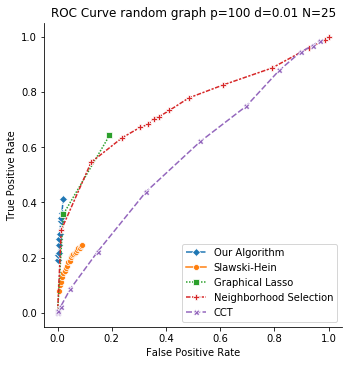

In [515]:
g = sns.relplot(x='False Positive Rate', y='True Positive Rate', data = agg_df, kind='line', 
            hue='Algorithm',
            hue_order=nice_names.keys(),
            style='Algorithm',
            markers = True,
            legend=False)
g.fig.get_axes()[0].legend(nice_names.values())
g.fig.get_axes()[0].set_title("ROC Curve random graph p={} d={} N={}".format(p,d,N))
g.fig.savefig("{}.png".format(run_name))